In [234]:
import sqlite3
import numpy as np
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.neighbors import KDTree
from sklearn.metrics import plot_confusion_matrix
import random
from sklearn.metrics import roc_curve,auc

In [166]:
conn = sqlite3.connect("final_2.sqlite")

In [167]:
d_f = pd.read_sql_query("SELECT * FROM Reviews",conna)

In [168]:
d_f.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,Cleaned_Summary
0,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...,thirty bucks
1,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons not beat great pr...,Flies Begone


In [169]:
#### BOW vectorisation

In [138]:
model = CountVectorizer(min_df = 10 , max_features = 1500)
BOW_1500d = model.fit_transform(d_f["Cleaned_text"])
BOW_1500d.shape

(4986, 1500)

In [139]:
### per = 30
tsne_model = TSNE(n_components = 2 ,n_iter = 1000 , perplexity = 30)
BOW_2d = tsne_model.fit_transform(BOW_1500d)


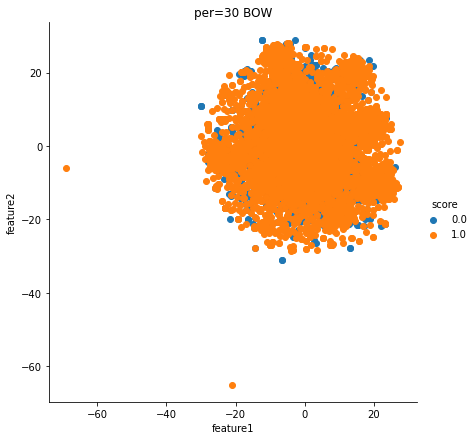

In [140]:
BOW_3d = np.vstack((BOW_2d.T , d_f["Score"])).T
BOW_df = pd.DataFrame(data = BOW_3d , columns = ("feature1" , "feature2" ,"score"))
### plotting
sns.FacetGrid(BOW_df ,hue="score" , height = 6).map(plt.scatter , "feature1" ,"feature2" ).add_legend()
plt.title("per=30 BOW")
plt.show()

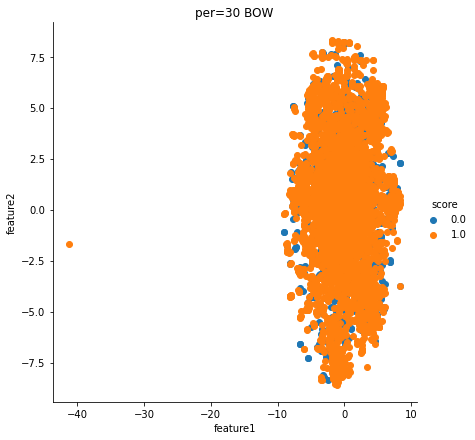

In [141]:
### per = 100
tsne_model = TSNE(n_components = 2 ,n_iter = 1000 , perplexity = 100)
BOW_2d = tsne_model.fit_transform(BOW_1500d)
BOW_3d = np.vstack((BOW_2d.T , d_f["Score"])).T
BOW_df = pd.DataFrame(data = BOW_3d , columns = ("feature1" , "feature2" ,"score"))
### plotting
sns.FacetGrid(BOW_df ,hue="score" , height = 6).map(plt.scatter , "feature1" ,"feature2" ).add_legend()
plt.title("per=30 BOW")
plt.show()

In [11]:
### splitting the data_set into train and test sets
x_train , x_test , y_train , y_test = model_selection.train_test_split( BOW_1500d , d_f["Score"] , test_size = 0.3 ,random_state = 5)

In [12]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3490, 1500)
(1496, 1500)
(3490,)
(1496,)


In [13]:
#### bruteforce k
k = 5
knn = KNeighborsClassifier(n_neighbors = k , weights = "distance")
knn.fit(x_train , y_train)
predicted_values = knn.predict(x_test)
accuracy = accuracy_score(y_test , predicted_values , normalize = True)*float(100)
print("accuracy for k= %d is %d"%(k,accuracy))

accuracy for k= 5 is 83


In [14]:
d_f["Score"].value_counts()

1    4178
0     808
Name: Score, dtype: int64

In [15]:
print(np.count_nonzero(predicted_values==1))
print(np.count_nonzero(predicted_values==0))

1460
36


In [16]:
### as we can see the percentage of data point having d_f["Score"] ==1 are 83.79%,,,so this model is dumb model
#### grid search for optimal k using 10 fold cv
k = list(range(0,50))
k = list(filter(lambda x : x%2 != 0,k))
cv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors = i, weights = "distance")
    accuracy = model_selection.cross_val_score(model , x_train , y_train ,cv = 10 , scoring = "accuracy")*float(100)
    print("for k = %d accuracy is %d"%(i,accuracy.mean()))
    cv.append(accuracy.mean())

optimal_k = k[cv.index(max(cv))]
    
print("optimal_k is %d" %optimal_k)

for k = 1 accuracy is 81
for k = 3 accuracy is 84
for k = 5 accuracy is 84
for k = 7 accuracy is 84
for k = 9 accuracy is 84
for k = 11 accuracy is 84
for k = 13 accuracy is 84
for k = 15 accuracy is 84
for k = 17 accuracy is 84
for k = 19 accuracy is 84
for k = 21 accuracy is 84
for k = 23 accuracy is 84
for k = 25 accuracy is 84
for k = 27 accuracy is 84
for k = 29 accuracy is 84
for k = 31 accuracy is 84
for k = 33 accuracy is 84
for k = 35 accuracy is 84
for k = 37 accuracy is 84
for k = 39 accuracy is 84
for k = 41 accuracy is 84
for k = 43 accuracy is 84
for k = 45 accuracy is 84
for k = 47 accuracy is 84
for k = 49 accuracy is 84
optimal_k is 5


In [17]:
### accuracy score on unseen test data at k=5
knn = KNeighborsClassifier(n_neighbors = optimal_k , weights = "distance")
knn.fit(x_train , y_train)
predicted_y = knn.predict(x_test)
accuracy = accuracy_score( y_test , predicted_y , normalize = True)*float(100)
print("for k= %d accuracy is %d"%(optimal_k , accuracy))

for k= 5 accuracy is 83


In [18]:
print(np.count_nonzero(predicted_y ==1))
print(np.count_nonzero(predicted_y ==0))

1460
36


In [170]:
### bigram _knn
model = CountVectorizer(min_df = 10 , max_features = 1500 , ngram_range = (1,2))
bi_gram_1500d = model.fit_transform(d_f["Cleaned_text"])
bi_gram_1500d.shape

(4986, 1500)

In [171]:
model.get_feature_names()[:10]

['able',
 'able find',
 'absolute',
 'absolutely',
 'absolutely love',
 'acid',
 'across',
 'actual',
 'actually',
 'add']

In [21]:
x_train , x_test , y_train , y_test =  model_selection.train_test_split(bi_gram_1500d , d_f["Score"] , test_size = 0.3)

In [22]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3490, 1500)
(1496, 1500)
(3490,)
(1496,)


In [23]:
#### grid search for optimal k using 10 fold cv on bi_gram
k = list(range(0,50))
k = list(filter(lambda x : x%2 != 0,k))
cv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors = i, weights = "distance")
    accuracy = model_selection.cross_val_score(model , x_train , y_train ,cv = 10 , scoring = "accuracy")*float(100)
    print("for k = %d accuracy is %d"%(i,accuracy.mean()))
    cv.append(accuracy.mean())

optimal_k = k[cv.index(max(cv))]
print("optimal_k is %d" %optimal_k)

for k = 1 accuracy is 76
for k = 3 accuracy is 81
for k = 5 accuracy is 82
for k = 7 accuracy is 83
for k = 9 accuracy is 83
for k = 11 accuracy is 83
for k = 13 accuracy is 83
for k = 15 accuracy is 83
for k = 17 accuracy is 83
for k = 19 accuracy is 83
for k = 21 accuracy is 83
for k = 23 accuracy is 83
for k = 25 accuracy is 83
for k = 27 accuracy is 83
for k = 29 accuracy is 83
for k = 31 accuracy is 83
for k = 33 accuracy is 83
for k = 35 accuracy is 83
for k = 37 accuracy is 83
for k = 39 accuracy is 83
for k = 41 accuracy is 83
for k = 43 accuracy is 83
for k = 45 accuracy is 83
for k = 47 accuracy is 83
for k = 49 accuracy is 83
optimal_k is 11


In [24]:
### accuracy score on unseen test data at k=49
knn = KNeighborsClassifier(n_neighbors = optimal_k , weights = "distance")
knn.fit(x_train , y_train)
predicted_y = knn.predict(x_test)
accuracy = accuracy_score( y_test , predicted_y , normalize = True)*float(100)
print("for k= %d accuracy is %d"%(optimal_k , accuracy))

for k= 11 accuracy is 84


In [25]:
print(np.count_nonzero(predicted_y ==1))
print(np.count_nonzero(predicted_y ==0))

1475
21


In [189]:
#### tfidf_vectorisation

tfidf  = TfidfVectorizer( min_df = 10 ,max_features = 1500)
tfidf_model = tfidf.fit(d_f["Cleaned_text"])
print("some feature names of the tfidf are" ,tfidf_model.get_feature_names()[0:10])

tfidf_vector = tfidf_model.transform(d_f["Cleaned_text"])
print("the shape of tfidf vector is", tfidf_vector.shape)

some feature names of the tfidf are ['able', 'absolute', 'absolutely', 'according', 'acid', 'across', 'actual', 'actually', 'add', 'added']
the shape of tfidf vector is (4986, 1500)


In [27]:
## train , test splitting()

x_train , x_test , y_train , y_test =  model_selection.train_test_split(tfidf_vector , d_f["Score"] , test_size = 0.3)

In [28]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3490, 1500)
(1496, 1500)
(3490,)
(1496,)


In [29]:
#### grid search for optimal k using 10 fold cv on tfidf_vectors
k = list(range(0,50))
k = list(filter(lambda x : x%2 != 0,k))
cv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors = i, weights = "distance")
    accuracy = model_selection.cross_val_score(model , x_train , y_train ,cv = 10 , scoring = "accuracy")*float(100)
    print("for k = %d accuracy is %d"%(i,accuracy.mean()))
    cv.append(accuracy.mean())

optimal_k = k[cv.index(max(cv))]
print("optimal_k is %d" %optimal_k)

for k = 1 accuracy is 78
for k = 3 accuracy is 83
for k = 5 accuracy is 83
for k = 7 accuracy is 84
for k = 9 accuracy is 84
for k = 11 accuracy is 85
for k = 13 accuracy is 85
for k = 15 accuracy is 85
for k = 17 accuracy is 84
for k = 19 accuracy is 84
for k = 21 accuracy is 84
for k = 23 accuracy is 84
for k = 25 accuracy is 84
for k = 27 accuracy is 84
for k = 29 accuracy is 84
for k = 31 accuracy is 84
for k = 33 accuracy is 84
for k = 35 accuracy is 84
for k = 37 accuracy is 84
for k = 39 accuracy is 84
for k = 41 accuracy is 84
for k = 43 accuracy is 84
for k = 45 accuracy is 84
for k = 47 accuracy is 84
for k = 49 accuracy is 84
optimal_k is 11


In [30]:
### accuracy score on unseen test data at k=11
knn = KNeighborsClassifier(n_neighbors = optimal_k , weights = "distance")
knn.fit(x_train , y_train)
predicted_y = knn.predict(x_test)
accuracy = accuracy_score( y_test , predicted_y , normalize = True)*float(100)
print("for k= %d accuracy is %d"%(optimal_k , accuracy))

for k= 11 accuracy is 84


In [31]:
print(np.count_nonzero(predicted_y ==1))
print(np.count_nonzero(predicted_y ==0))

1459
37


In [32]:
#### Word2vec

i=0
list_of_sentence = []
for sentence in tqdm(d_f["Cleaned_text"]):
    list_of_sentence.append(sentence.split())
w2v = Word2Vec(list_of_sentence , size= 50 , min_count = 5)
w2v_words = list(w2v.wv.vocab)
print(type(w2v_words))
print(len(w2v_words))

100%|███████████████████████████████████████████████████████████████████████████| 4986/4986 [00:00<00:00, 47467.17it/s]


<class 'list'>
3989


In [33]:
## average_w2v

total_vector = []
for sentance in list_of_sentence:
    sen_vector = np.zeros(50)
    count = 0
    for word in sentance:
        if word in w2v_words:
            count = count + 1
            sen_vector += w2v.wv[word]
        if count != 0:
            sen_vector = sen_vector/count
    total_vector.append(sen_vector)

In [34]:
print(len(total_vector))
print(len(total_vector[0]))

4986
50


In [35]:
average_w2v = np.asarray(total_vector)

In [36]:
x_train , x_test , y_train , y_test =  model_selection.train_test_split(average_w2v , d_f["Score"] , test_size = 0.3)

In [37]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3490, 50)
(1496, 50)
(3490,)
(1496,)


In [38]:
#### grid search for optimal k using 10 fold cv on aerage_w2v
k = list(range(0,50))
k = list(filter(lambda x : x%2 != 0,k))
cv = []
for i in tqdm(k):
    model = KNeighborsClassifier(n_neighbors = i, weights = "distance")
    accuracy = model_selection.cross_val_score(model , x_train , y_train ,cv = 10 , scoring = "accuracy")*float(100)
    print("for k = %d accuracy is %d"%(i,accuracy.mean()))
    cv.append(accuracy.mean())

optimal_k = k[cv.index(max(cv))]
print("optimal_k is %d" %optimal_k)

  4%|███▎                                                                               | 1/25 [00:01<00:43,  1.81s/it]

for k = 1 accuracy is 75


  8%|██████▋                                                                            | 2/25 [00:03<00:42,  1.87s/it]

for k = 3 accuracy is 78


 12%|█████████▉                                                                         | 3/25 [00:05<00:43,  1.96s/it]

for k = 5 accuracy is 80


 16%|█████████████▎                                                                     | 4/25 [00:08<00:44,  2.10s/it]

for k = 7 accuracy is 80


 20%|████████████████▌                                                                  | 5/25 [00:10<00:43,  2.16s/it]

for k = 9 accuracy is 81


 24%|███████████████████▉                                                               | 6/25 [00:13<00:42,  2.26s/it]

for k = 11 accuracy is 81


 28%|███████████████████████▏                                                           | 7/25 [00:15<00:42,  2.33s/it]

for k = 13 accuracy is 82


 32%|██████████████████████████▌                                                        | 8/25 [00:18<00:40,  2.37s/it]

for k = 15 accuracy is 82


 36%|█████████████████████████████▉                                                     | 9/25 [00:20<00:39,  2.48s/it]

for k = 17 accuracy is 82


 40%|████████████████████████████████▊                                                 | 10/25 [00:23<00:37,  2.49s/it]

for k = 19 accuracy is 82


 44%|████████████████████████████████████                                              | 11/25 [00:26<00:35,  2.52s/it]

for k = 21 accuracy is 82


 48%|███████████████████████████████████████▎                                          | 12/25 [00:28<00:33,  2.58s/it]

for k = 23 accuracy is 83


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:31<00:30,  2.58s/it]

for k = 25 accuracy is 83


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:34<00:29,  2.66s/it]

for k = 27 accuracy is 83


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:36<00:26,  2.66s/it]

for k = 29 accuracy is 83


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:39<00:24,  2.70s/it]

for k = 31 accuracy is 83


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:42<00:21,  2.72s/it]

for k = 33 accuracy is 83


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:45<00:19,  2.72s/it]

for k = 35 accuracy is 83


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:48<00:16,  2.78s/it]

for k = 37 accuracy is 83


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:50<00:13,  2.76s/it]

for k = 39 accuracy is 83


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:53<00:11,  2.82s/it]

for k = 41 accuracy is 83


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:56<00:08,  2.80s/it]

for k = 43 accuracy is 83


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:59<00:05,  2.85s/it]

for k = 45 accuracy is 83


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [01:02<00:02,  2.84s/it]

for k = 47 accuracy is 83


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:05<00:00,  2.60s/it]

for k = 49 accuracy is 83
optimal_k is 41


In [39]:
### accuracy score on unseen test data at k=optimal_k
knn = KNeighborsClassifier(n_neighbors = optimal_k , weights = "distance")
knn.fit(x_train , y_train)
predicted_y = knn.predict(x_test)
accuracy = accuracy_score( y_test , predicted_y , normalize = True)*float(100)
print("for k= %d accuracy is %d"%(optimal_k , accuracy))

for k= 41 accuracy is 83


In [40]:
print(np.count_nonzero(predicted_y ==1))
print(np.count_nonzero(predicted_y ==0))

1488
8


In [41]:
#### tfidf_weighted_vector
model = TfidfVectorizer()
model.fit(d_f["Cleaned_text"])
#### now we are zipping words with their idf_ value pay attention it is not tfidf value
dictionary = dict(zip(model.get_feature_names(),list(model.idf_)))
tfidf_weighted_w2v = []
tfidf_feat = model.get_feature_names()
for sent in tqdm(list_of_sentence):
    sentance_vector = np.zeros(50)
    tfidf_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sentance_vector += (w2v.wv[word]*tfidf)
            tfidf_sum += tfidf
        if tfidf_sum != 0:
            sentance_vector /= tfidf_sum
    tfidf_weighted_w2v.append(sentance_vector)
            

100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [03:52<00:00, 21.42it/s]


In [42]:
print(len(tfidf_weighted_w2v))
print(len(tfidf_weighted_w2v[0]))
print(type(tfidf_weighted_w2v))

4986
50
<class 'list'>


In [43]:
average_w2v = np.asarray(tfidf_weighted_w2v)

In [44]:
x_train , x_test , y_train , y_test =  model_selection.train_test_split(average_w2v , d_f["Score"] , test_size = 0.3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3490, 50)
(1496, 50)
(3490,)
(1496,)


In [45]:
#### grid search for optimal k using 10 fold cv on aerage_w2v
k = list(range(0,50))
k = list(filter(lambda x : x%2 != 0,k))
cv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors = i, weights = "distance")
    accuracy = model_selection.cross_val_score(model , x_train , y_train ,cv = 10 , scoring = "accuracy")*float(100)
    print("for k = %d accuracy is %d"%(i,accuracy.mean()))
    cv.append(accuracy.mean())

optimal_k = k[cv.index(max(cv))]
print("optimal_k is %d" %optimal_k)

for k = 1 accuracy is 73
for k = 3 accuracy is 78
for k = 5 accuracy is 80
for k = 7 accuracy is 81
for k = 9 accuracy is 81
for k = 11 accuracy is 82
for k = 13 accuracy is 82
for k = 15 accuracy is 82
for k = 17 accuracy is 82
for k = 19 accuracy is 82
for k = 21 accuracy is 83
for k = 23 accuracy is 83
for k = 25 accuracy is 83
for k = 27 accuracy is 83
for k = 29 accuracy is 83
for k = 31 accuracy is 83
for k = 33 accuracy is 83
for k = 35 accuracy is 83
for k = 37 accuracy is 83
for k = 39 accuracy is 83
for k = 41 accuracy is 83
for k = 43 accuracy is 83
for k = 45 accuracy is 83
for k = 47 accuracy is 83
for k = 49 accuracy is 83
optimal_k is 43


In [46]:
### accuracy score on unseen test data at k=optimal_k
knn = KNeighborsClassifier(n_neighbors = optimal_k , weights = "distance")
knn.fit(x_train , y_train)
predicted_y = knn.predict(x_test)
accuracy = accuracy_score( y_test , predicted_y , normalize = True)*float(100)
print("for k= %d accuracy is %d"%(optimal_k , accuracy))

for k= 43 accuracy is 85


In [47]:
###### implementation of kd tree version of knn

In [68]:
bow_vectors = np.asarray(BOW_1500d)

In [49]:
##predicted_values = []
##tree = KDTree(bow_vectors , leaf_size = 20)
##for x in x_test:
  ##  distance , idx= tree.query(x , k=5)
   ## positive = np.count_nonzeros(d_f["Score"][idx]==1)
    ##negative = np.count_nonzeros(d_f["Score"][idx]==0)
   ## if positive > negative:
     ##   predicted_values.append(1)
  ##  else:
    ##    predicted_values.append(0)
        

#######   applying naive baise assignment 04 on amazon fine food reviews data set

In [209]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score
import sklearn

In [143]:
clf_model = BernoulliNB()

In [144]:
x = BOW_1500d
y = d_f["Score"]

In [145]:
x_train , x_test , y_train , y_test = model_selection.train_test_split(x , y , test_size = 0.3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3490, 1500)
(1496, 1500)
(3490,)
(1496,)


In [146]:
clf_model.fit(x_train,y_train)

BernoulliNB()

In [147]:
y_predicted = clf_model.predict(x_test)

In [148]:
print(np.count_nonzero(y_predicted==0))
print(np.count_nonzero(y_predicted==1))

229
1267


In [149]:
print(np.count_nonzero(y_test==0))
print(np.count_nonzero(y_test==1))

250
1246


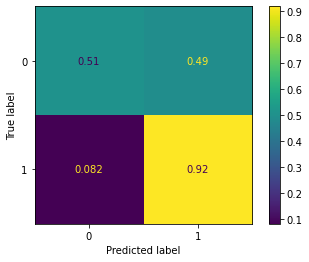

In [150]:
plot = plot_confusion_matrix(clf_model ,x_test ,y_test,normalize = "true" ,labels = (0,1))

In [151]:
#### using different alpha

In [152]:
clf_model = BernoulliNB(alpha = 5 , fit_prior = True)

In [153]:
clf_model.fit(x_train,y_train)

BernoulliNB(alpha=5)

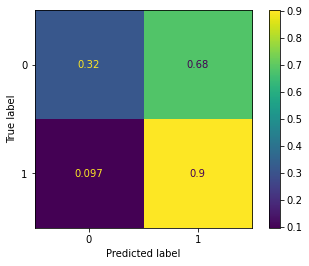

In [154]:
plot_confusion_matrix(clf_model , x_test , y_test , labels = (0,1) ,normalize = 'true')

In [155]:
## using alpha =n

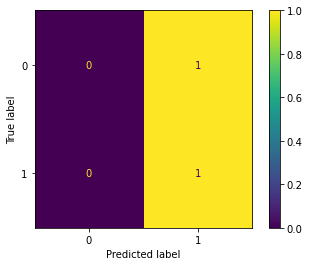

In [156]:
clf_model = BernoulliNB(alpha = 1486 , fit_prior = True)
clf_model.fit(x_train,y_train)
plot_confusion_matrix(clf_model , x_test , y_test , labels = (0,1) ,normalize = 'true')

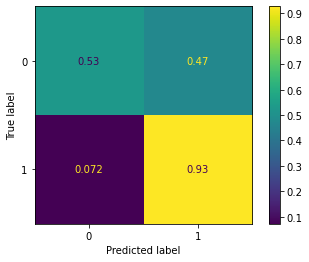

In [157]:
##### alpha = 0.5
clf_model = BernoulliNB(alpha = 0.5 , fit_prior = True)
clf_model.fit(x_train,y_train)
plot_confusion_matrix(clf_model , x_test , y_test , labels = (0,1) ,normalize = 'true')

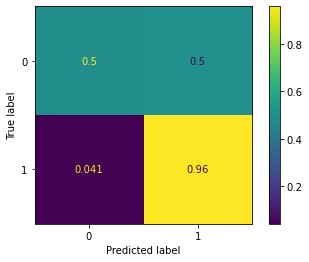

In [158]:
##### alpha = 0.001
clf_model = BernoulliNB(alpha = 0.001 , fit_prior = True)
clf_model.fit(x_train,y_train)
plot_confusion_matrix(clf_model , x_test , y_test , labels = (0,1) ,normalize = 'true')

In [159]:
###### figuring top 10 most important features for positive as well as negatiove class
##### feature_log_prob_ is an attribute of bernoullinb() which returns an 2d array with log probabilities of all features
positive_class_important_feat = clf_model.feature_log_prob_[1,:].argsort()[::-1]
negative_class_important_feat = clf_model.feature_log_prob_[0,:].argsort()[::-1]

### printing most important features

print("important features of positive class")
print(np.take(model.get_feature_names(),positive_class_important_feat[:10]))
print(np.take(model.get_feature_names(),negative_class_important_feat[:10]))

important features of positive class
['good' 'great' 'like' 'love' 'one' 'taste' 'product' 'flavor' 'would'
 'best']
['like' 'would' 'taste' 'product' 'one' 'good' 'even' 'flavor' 'tried'
 'much']


In [176]:
x = bi_gram_1500d
y = d_f["Score"]
x_train , x_test , y_train , y_test = model_selection.train_test_split(x , y , test_size = 0.3)

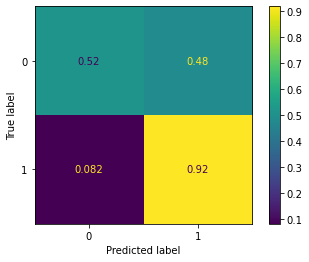

In [177]:
#### bigram_1500d

clf_model = BernoulliNB(fit_prior = True)
clf_model.fit(x_train , y_train)
plot_confusion_matrix(clf_model , x_test , y_test , labels = (0,1),normalize = 'true')

In [178]:
###### figuring top 10 most important features for positive as well as negatiove class
##### feature_log_prob_ is an attribute of bernoullinb() which returns an 2d array with log probabilities of all features
positive_class_important_feat = clf_model.feature_log_prob_[1,:].argsort()[::-1]
negative_class_important_feat = clf_model.feature_log_prob_[0,:].argsort()[::-1]

### printing most important features

print("important features of positive class")
print(np.take(model.get_feature_names(),positive_class_important_feat[:10]))
print(np.take(model.get_feature_names(),negative_class_important_feat[:10]))

important features of positive class
['not' 'good' 'great' 'like' 'love' 'taste' 'one' 'product' 'flavor'
 'would']
['not' 'like' 'would' 'taste' 'product' 'one' 'good' 'flavor' 'even' 'buy']


In [190]:
####### naive bayes on tfidf

x = tfidf_vector
y = d_f["Score"]
x_train , _test , y_train ,y_test = model_selection.train_test_split(x ,y , test_size = 0.3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3490, 1500)
(1496, 1500)
(3490,)
(1496,)


In [191]:
clf = BernoulliNB(fit_prior = True , alpha =1)
clf.fit(x_train , y_train)


BernoulliNB(alpha=1)

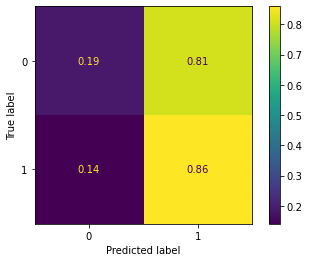

In [193]:
plot_confusion_matrix(clf_model , x_test , y_test , labels = (0,1),normalize = 'true')

In [194]:
###### figuring top 10 most important features for positive as well as negatiove class
##### feature_log_prob_ is an attribute of bernoullinb() which returns an 2d array with log probabilities of all features
positive_class_important_feat = clf.feature_log_prob_[1,:].argsort()[::-1]
negative_class_important_feat = clf.feature_log_prob_[0,:].argsort()[::-1]

### printing most important features

print("important features of positive class")
print(np.take(model.get_feature_names(),positive_class_important_feat[:10]))
print(np.take(model.get_feature_names(),negative_class_important_feat[:10]))

important features of positive class
['not disappointed' 'grocery stores' 'great not' 'lime' 'loved'
 'tastes good' 'not work' 'potatoes' 'free' 'would never']
['not disappointed' 'lime' 'would never' 'tastes good' 'potatoes'
 'not work' 'great not' 'fair' 'free' 'candy']


In [204]:
#### random search for optimal alpha using 10 fold cv on tfidf
x = random.sample(range(1,700),30)
cv = []
for i in x:
    clf_model = BernoulliNB(fit_prior = True ,alpha = i)
    accuracy = model_selection.cross_val_score(clf_model , x_train , y_train ,cv = 10 , scoring = "accuracy")*float(100)
    print("for alpha = %d accuracy is %d"%(i,accuracy.mean()))
    cv.append(accuracy.mean())

optimal_alpha = k[cv.index(max(cv))]
print("optimal_alpha is %d" %optimal_k)

for alpha = 139 accuracy is 82
for alpha = 601 accuracy is 82
for alpha = 251 accuracy is 82
for alpha = 638 accuracy is 82
for alpha = 137 accuracy is 82
for alpha = 500 accuracy is 82
for alpha = 449 accuracy is 82
for alpha = 483 accuracy is 82
for alpha = 288 accuracy is 82
for alpha = 227 accuracy is 82
for alpha = 22 accuracy is 81
for alpha = 468 accuracy is 82
for alpha = 10 accuracy is 80
for alpha = 194 accuracy is 82
for alpha = 354 accuracy is 82
for alpha = 482 accuracy is 82
for alpha = 547 accuracy is 82
for alpha = 461 accuracy is 82
for alpha = 530 accuracy is 82
for alpha = 166 accuracy is 82
for alpha = 383 accuracy is 82
for alpha = 394 accuracy is 82
for alpha = 9 accuracy is 80
for alpha = 107 accuracy is 82
for alpha = 14 accuracy is 81
for alpha = 114 accuracy is 82
for alpha = 563 accuracy is 82
for alpha = 370 accuracy is 82
for alpha = 335 accuracy is 82
for alpha = 102 accuracy is 82
optimal_alpha is 21


In [228]:
#### f1_score
optimal_score = 0*float()
optimum_alpha = 0
x = random.sample(range(1,700),30)
cv = []
for i in x:
    clf_model = BernoulliNB(fit_prior = True ,alpha = i)
    clf_model.fit(x_train , y_train)
    predicted_y = clf_model.predict(x_test)
    score = f1_score(y_test , predicted_y)
    print("for alpha = %d accuracy is %f"%(i,score))
    if(optimal_score<=score):
        optimum_score = score
        optimum_alpha = i

for alpha = 681 accuracy is 0.923741
for alpha = 244 accuracy is 0.923741
for alpha = 426 accuracy is 0.923741
for alpha = 365 accuracy is 0.923741
for alpha = 299 accuracy is 0.923741
for alpha = 613 accuracy is 0.923741
for alpha = 545 accuracy is 0.923741
for alpha = 138 accuracy is 0.922966
for alpha = 652 accuracy is 0.923741
for alpha = 121 accuracy is 0.922966
for alpha = 470 accuracy is 0.923741
for alpha = 256 accuracy is 0.923741
for alpha = 271 accuracy is 0.923741
for alpha = 670 accuracy is 0.923741
for alpha = 283 accuracy is 0.923741
for alpha = 42 accuracy is 0.912281
for alpha = 594 accuracy is 0.923741
for alpha = 324 accuracy is 0.923741
for alpha = 161 accuracy is 0.922966
for alpha = 419 accuracy is 0.923741
for alpha = 267 accuracy is 0.923741
for alpha = 599 accuracy is 0.923741
for alpha = 449 accuracy is 0.923741
for alpha = 521 accuracy is 0.923741
for alpha = 591 accuracy is 0.923741
for alpha = 127 accuracy is 0.922966
for alpha = 636 accuracy is 0.923741
fo

In [229]:
print(optimal_alpha)
print(x)

47
[681, 244, 426, 365, 299, 613, 545, 138, 652, 121, 470, 256, 271, 670, 283, 42, 594, 324, 161, 419, 267, 599, 449, 521, 591, 127, 636, 33, 287, 159]


In [240]:
no_of_test_data =len(y_test)
for i in range(no_of_test_data):
    fpr , tpr = roc_curve(y_test[0], predicted_y[1])
    roc_auc[i] = auc(fpr[i],tpr[i])

KeyError: 0

1496